# Image Classification
In this project, I am classifying images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  
The dataset consists of airplanes, dogs, cats, and other objects. 


Objective:
- Preprocess the images
- Train a convolutional neural network on all the samples, implementing max pooling, dropout, and fully connected layers
- Normalize the images and one-hot encode labels  
- Obtain predictions by the created neural network on the sample images

## Get the Data
The following code cell downloads the data 
[CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 0:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


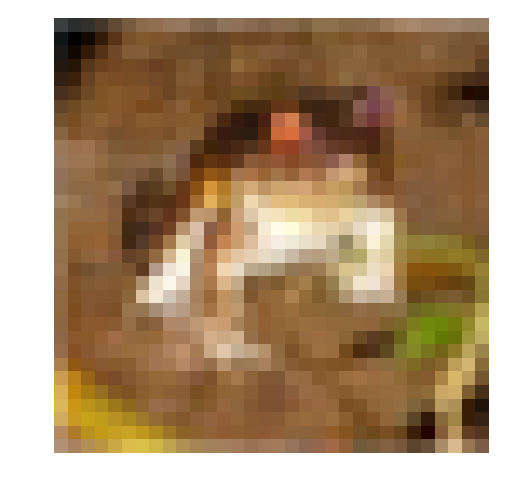

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset (Example)
batch_id = 1
sample_id = 0
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocessing the Data
### Normalize
Implementing the `normalize` function that takes in image data, `x`, and returns it as a normalized Numpy array such that the values should be in the range of 0 to 1, inclusive.  The returned object's shape is the same shape as `x`.

In [4]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = x/255
    return x

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Implementing the `one_hot_encode` function that inputs `x`, which is a list of labels and return the list of labels as One-Hot encoded Numpy array with values between 0 and 9. The one-hot encoding function returns the same encoding for each value between each call to `one_hot_encode`.

In [5]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return np.eye(10)[x]

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [6]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [7]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

### Input
The neural network reads the image data, one-hot encoded labels, and dropout keep probability

Functions imeplemented are as below:
* `neural_net_image_input`
 * Returns a TF Placeholder
 * Sets the shape using `image_shape` with batch size set to `None`
 * Naming the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the TF Placeholder

* `neural_net_label_input`
 * Returns a TF Placeholder
 * Sets the shape using `n_classes` with batch size set to `None`
 * Naming the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the TF Placeholder
 
* `neural_net_keep_prob_input`
 * Returns a TF Placeholder for dropout keep probability.
 * Naming the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the TF Placeholder

Note: These names will be used at the end of the project to load the saved model

`None` for shapes in TensorFlow allows for a dynamic size

In [8]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, [None, *image_shape], "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, [None, n_classes], name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name="keep_prob")

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. 
Implementing the function `conv2d_maxpool` to apply convolution then max pooling as below:
* Creating the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Applying a convolution to `x_tensor` using weight and `conv_strides`.
 * I am choosing to use same padding
* Adding bias
* Adding a nonlinear activation to the convolution
* Applying Max Pooling using `pool_ksize` and `pool_strides`
 * Implementing with same padding


In [9]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], int(x_tensor.shape[3]),
                                              conv_num_outputs], stddev=0.05))
    
    bias = tf.zeros(shape=[conv_num_outputs])
    bias.set_shape([conv_num_outputs]) 
    
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides = [1, *conv_strides, 1], padding = "SAME")
    conv_layer_with_bias = tf.nn.bias_add(conv_layer, bias)
    conv_layer_with_activation = tf.nn.relu(conv_layer_with_bias)
    conv_layer_after_pooling = tf.nn.max_pool(conv_layer_with_activation, ksize= [1, *pool_ksize, 1], strides = [1, *pool_strides, 1], padding = "SAME")
    return conv_layer_after_pooling


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implementing the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output shape would be: (*Batch Size*, *Flattened Image Size*).

In [10]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.reshape(x_tensor, [-1, int(x_tensor.shape[1] * x_tensor.shape[2] * x_tensor.shape[3])])

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implementing the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*)

In [11]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Shortcut: return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=tf.nn.relu)
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=0.05))
    
    bias = tf.zeros(shape=[num_outputs])

    fully_connected_layer = tf.add(tf.matmul(x_tensor, weights), bias)
    
    fully_connected_layer = tf.nn.relu(fully_connected_layer)
    
    return fully_connected_layer

tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply an output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=0.05))
    
    bias = tf.zeros(shape=[num_outputs])

    output_layer = tf.add(tf.matmul(x_tensor, weights), bias)
    
    # output_layer = tf.nn.sigmoid(output_layer)
    # Adding sigmoid activation function as te Udacity Reviews calls out for Linear activation function for the output
    
    return output_layer

tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [16]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Apply Convolution and Max Pool layers
    conv1 = conv2d_maxpool(x_tensor=x, 
                           conv_num_outputs=32, 
                           conv_ksize=(4, 4), 
                           conv_strides=(1, 1), 
                           pool_ksize=(2, 2), 
                           pool_strides=(1, 1))
    conv2 = conv2d_maxpool(x_tensor=conv1,
                           conv_num_outputs=64,
                           conv_ksize=(2, 2),
                           conv_strides=(1, 1),
                           pool_ksize=(2, 2),
                           pool_strides=(1, 1))
    

    # Apply a Flatten Layer
    flattened_layer = flatten(conv2)
    

    # Apply Fully Connected Layers
    fully_con_layer1 = fully_conn(flattened_layer, num_outputs = 64)
    fully_con_layer1_with_dropout = tf.nn.dropout(fully_con_layer1, keep_prob)
    
    fully_con_layer2 = fully_conn(fully_con_layer1_with_dropout, num_outputs = 32)
    fully_con_layer2_with_dropout = tf.nn.dropout(fully_con_layer2, keep_prob)
    
    
    # Apply an Output Layer
    output_layer = output(fully_con_layer2_with_dropout, num_outputs = 10)
    
    return output_layer


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implementing the function `train_neural_network` to do a single optimization.  The optimization uses `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: This function is only optimizing the neural network and does not return any value

In [17]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, {x: feature_batch, y: label_batch, keep_prob: keep_probability})

tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implementing the function `print_stats` to print loss and validation accuracy.  The validation accuracy is calculated using the global variables `valid_features` and `valid_labels`. Also, using a keep probability of `1.0` here to calculate the loss and validation accuracy.

In [18]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    
    print('Loss: {:>15.4f} Validation Accuracy: {:.4f}'.format(loss, valid_acc))

### Hyperparameters
Tuning the following hyper parameters:
* `epochs` 
* `batch_size` 
* `keep_probability` 

In [21]:
# Tuning Parameters
epochs = 20
batch_size = 128
keep_probability = 0.8

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's start with a single batch. This saves time while we iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, we can run the model on all the data.

In [22]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:          2.1351 Validation Accuracy: 0.2968
Epoch  2, CIFAR-10 Batch 1:  Loss:          1.9861 Validation Accuracy: 0.3926
Epoch  3, CIFAR-10 Batch 1:  Loss:          1.8430 Validation Accuracy: 0.4370
Epoch  4, CIFAR-10 Batch 1:  Loss:          1.7040 Validation Accuracy: 0.4534
Epoch  5, CIFAR-10 Batch 1:  Loss:          1.4305 Validation Accuracy: 0.4732
Epoch  6, CIFAR-10 Batch 1:  Loss:          1.3035 Validation Accuracy: 0.4672
Epoch  7, CIFAR-10 Batch 1:  Loss:          1.1419 Validation Accuracy: 0.5028
Epoch  8, CIFAR-10 Batch 1:  Loss:          1.0575 Validation Accuracy: 0.4912
Epoch  9, CIFAR-10 Batch 1:  Loss:          0.9983 Validation Accuracy: 0.5128
Epoch 10, CIFAR-10 Batch 1:  Loss:          0.8793 Validation Accuracy: 0.5368
Epoch 11, CIFAR-10 Batch 1:  Loss:          0.8238 Validation Accuracy: 0.5322
Epoch 12, CIFAR-10 Batch 1:  Loss:          0.7945 Validation Accuracy: 0.5180
Epoch 13,

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [24]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:          2.0496 Validation Accuracy: 0.3332
Epoch  1, CIFAR-10 Batch 2:  Loss:          1.6625 Validation Accuracy: 0.4114
Epoch  1, CIFAR-10 Batch 3:  Loss:          1.3769 Validation Accuracy: 0.4436
Epoch  1, CIFAR-10 Batch 4:  Loss:          1.4886 Validation Accuracy: 0.4650
Epoch  1, CIFAR-10 Batch 5:  Loss:          1.3706 Validation Accuracy: 0.4782
Epoch  2, CIFAR-10 Batch 1:  Loss:          1.7921 Validation Accuracy: 0.4828
Epoch  2, CIFAR-10 Batch 2:  Loss:          1.2680 Validation Accuracy: 0.5094
Epoch  2, CIFAR-10 Batch 3:  Loss:          1.0134 Validation Accuracy: 0.5040
Epoch  2, CIFAR-10 Batch 4:  Loss:          1.2740 Validation Accuracy: 0.5230
Epoch  2, CIFAR-10 Batch 5:  Loss:          1.1936 Validation Accuracy: 0.5130
Epoch  3, CIFAR-10 Batch 1:  Loss:          1.4134 Validation Accuracy: 0.5390
Epoch  3, CIFAR-10 Batch 2:  Loss:          1.1769 Validation Accuracy: 0.5144
Epoch  3, CIFAR-10 Batch 3:  Loss:      

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.659315664556962



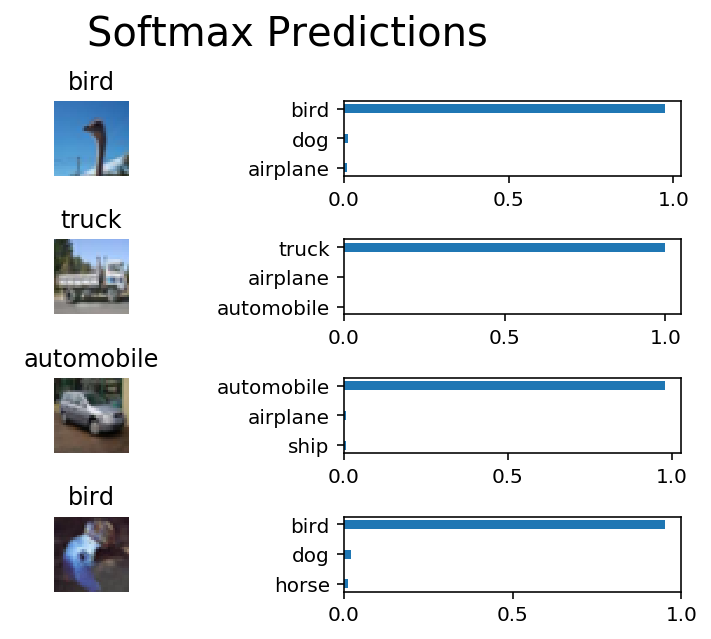

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Testing the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
Though 50% accuracy isn't bad for a simple CNN, it's not the best and can be improved. However, this is out of the scope of this project. 